In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
ROOT_DIR      = '/tf/ocr_credit_card/'
DATASET_DIR   = ROOT_DIR    + 'dataset/'
IMAGE_DIR     = DATASET_DIR + 'credit-card-mix/'
LABEL_PATH    = IMAGE_DIR   + 'CardNumberCoordinates.csv'
ARTIFACT_PATH = ROOT_DIR    + 'artifact/' 

IMAGE_SIZE = (410, 260)

In [3]:
def open_csv_pandas(filepath):
    return pd.read_csv(filepath, header=0,sep=',')

data = open_csv_pandas(LABEL_PATH)
data.head()

file    numX1     numY1     numX2     numY2    dateX1  \
0  aify1eaq6psin80bww4w.png  53.2379  144.2693  370.6573  164.9346  144.9919   
1  at6hpvnrabkyzdjn4ild.png  38.3589  145.0959  393.8024  170.7209  147.4718   
2  bcyis9vw25ljgn8ejyjp.png  33.3992  145.0959  363.2177  169.0677  125.9798   
3  bhlxuyoqr8v4wtcwsbby.jpg  30.9194  140.9629  386.3629  169.0677  180.5363   
4  bm5urhce7ml1jfbeczh0.png  31.7460  140.9629  375.6169  168.2411  201.2016   

     dateY1    dateX2    dateY2   nameX1    nameY1    nameX2    nameY2  
0  185.5999  239.2258  201.3056  36.7056  221.1443  205.3347  236.0233  
1  193.0395  251.6250  213.7048  26.7863  225.2774  178.8831  240.9830  
2  179.8137  239.2258  203.7854  21.8266  215.3580  278.0766  234.3701  
3  194.6927  249.9718  214.5314  19.3468  218.6645  273.9435  238.5032  
4  195.5193  249.9718  208.7451  35.0524  218.6645  241.7056  234.3701

## Data Preparation

𝑧𝑖=𝑥𝑖−min(𝑥)/max(𝑥)−min(𝑥)

In [4]:
def add_width_heigth(dataset, excludes):
    data_ex = dataset.drop(excludes, axis=1)
    columns = data_ex.columns
    n_columns = len(columns)
    i = 0
    while i < n_columns:
        if n_columns - i < 3:
            break
        diff = abs(data_ex[columns[i]] - data_ex[columns[i + 2]])
        if i % 2 == 0:
            name = columns[i][:-2] + 'Width'
            data_ex[name] = diff
            i += 1
        else:
            name = columns[i][:-2] + 'Height'
            data_ex[name] = diff
            i += 3
    for i in range(len(excludes)):
        data_ex[excludes[i]] = dataset[excludes[i]]
    return data_ex


def add_centre_coordinate(dataset, excludes):
    data_ex = dataset.drop(excludes, axis=1)
    columns = data_ex.columns
    n_columns = len(columns)
    for i in range(n_columns-1, 0, -1):
        if i == 10:
            break
        # Pythagorean theorem find the hypotenuse
        if i % 2 == 0:
            s = ((data_ex[columns[i]]**2) + (data_ex[columns[i-1]]**2))**(1/2)
            half_s = s / 2
            name = columns[i][:-5] + 'Centre'
            data_ex[name] = half_s
    for i in range(len(excludes)):
        data_ex[excludes[i]] = dataset[excludes[i]]
    return data_ex


def transform_numerical(dataset, excludes, min_x, max_x, min_y, max_y, calc):
    data_ex = dataset.copy()

    if len(excludes) == 1:
        data_ex = dataset.drop(excludes, axis=1)
        
    columns = data_ex.columns
    n_columns = len(columns)
    for i in range(n_columns):
        current = data_ex[columns[i]]
        if i % 2 == 0:
            data_ex[columns[i]] = calc(current, min_y, max_y)
        else:
            data_ex[columns[i]] = calc(current, min_x, max_x)   
            
    if len(excludes) == 1:
        for i in range(len(excludes)):
            data_ex[excludes[i]] = dataset[excludes[i]]
            
    return data_ex


## Normalization

In [5]:
normalizer = lambda x, min_val, max_val : (x - min_val) / (max_val - min_val)

inverse_normalizer = lambda x, min_val, max_val : (x * (max_val - min_val)) + min_val

In [6]:
def run_feature_engineer(dataset):
    data_ex = add_width_heigth(dataset, ['file'])
    data_ex = add_centre_coordinate(data_ex, ['file'])
    return data_ex

pre_data = run_feature_engineer(data)

In [7]:
pre_data.head()

numX1     numY1     numX2     numY2    dateX1    dateY1    dateX2  \
0  53.2379  144.2693  370.6573  164.9346  144.9919  185.5999  239.2258   
1  38.3589  145.0959  393.8024  170.7209  147.4718  193.0395  251.6250   
2  33.3992  145.0959  363.2177  169.0677  125.9798  179.8137  239.2258   
3  30.9194  140.9629  386.3629  169.0677  180.5363  194.6927  249.9718   
4  31.7460  140.9629  375.6169  168.2411  201.2016  195.5193  249.9718   

     dateY2   nameX1    nameY1  ...  numWidth  numHeight  dateWidth  \
0  201.3056  36.7056  221.1443  ...  317.4194    20.6653    94.2339   
1  213.7048  26.7863  225.2774  ...  355.4435    25.6250   104.1532   
2  203.7854  21.8266  215.3580  ...  329.8185    23.9718   113.2460   
3  214.5314  19.3468  218.6645  ...  355.4435    28.1048    69.4355   
4  208.7451  35.0524  218.6645  ...  343.8709    27.2782    48.7702   

   dateHeight  nameWidth  nameHeight  nameCentre  dateCentre   numCentre  \
0     15.7057   168.6291     14.8790   84.679458   48.236611  197.776435   
1     20.6653   152.0968     15.7056   76.747135   53.629585  214.716609   
2     23.9717   256.2500     19.0121  128.684406   57.877681  202.305207   
3     19.8387   254.5967     19.8387  127.684233   37.453866  214.023280   
4     13.2258   206.6532     15.7056  103.537996   27.940260  208.072427   

                       file  
0  aify1eaq6psin80bww4w.png  
1  at6hpvnrabkyzdjn4ild.png  
2  bcyis9vw25ljgn8ejyjp.png  
3  bhlxuyoqr8v4wtcwsbby.jpg  
4  bm5urhce7ml1jfbeczh0.png  

[5 rows x 22 columns]

In [8]:
final_data = transform_numerical(
    pre_data, excludes=['file'], 
    min_y=0, max_y=410, 
    min_x=0, max_x=260,
    calc=normalizer)

final_data.head()

numX1     numY1     numX2     numY2    dateX1    dateY1    dateX2  \
0  0.129849  0.554882  0.904042  0.634364  0.353639  0.713846  0.583478   
1  0.093558  0.558061  0.960494  0.656619  0.359687  0.742460  0.613720   
2  0.081461  0.558061  0.885897  0.650260  0.307268  0.691591  0.583478   
3  0.075413  0.542165  0.942349  0.650260  0.440332  0.748818  0.609687   
4  0.077429  0.542165  0.916139  0.647081  0.490736  0.751997  0.609687   

     dateY2    nameX1    nameY1  ...  numWidth  numHeight  dateWidth  \
0  0.774252  0.089526  0.850555  ...  0.774194   0.079482   0.229839   
1  0.821942  0.065332  0.866452  ...  0.866935   0.098558   0.254032   
2  0.783790  0.053236  0.828300  ...  0.804435   0.092199   0.276210   
3  0.825121  0.047187  0.841017  ...  0.866935   0.108095   0.169355   
4  0.802866  0.085494  0.841017  ...  0.838710   0.104916   0.118952   

   dateHeight  nameWidth  nameHeight  nameCentre  dateCentre  numCentre  \
0    0.060407   0.411290    0.057227    0.206535    0.185525   0.482382   
1    0.079482   0.370968    0.060406    0.187188    0.206268   0.523699   
2    0.092199   0.625000    0.073123    0.313864    0.222606   0.493427   
3    0.076303   0.620968    0.076303    0.311425    0.144053   0.522008   
4    0.050868   0.504032    0.060406    0.252532    0.107463   0.507494   

                       file  
0  aify1eaq6psin80bww4w.png  
1  at6hpvnrabkyzdjn4ild.png  
2  bcyis9vw25ljgn8ejyjp.png  
3  bhlxuyoqr8v4wtcwsbby.jpg  
4  bm5urhce7ml1jfbeczh0.png  

[5 rows x 22 columns]

## Read Image

In [9]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img


def load_images(im_directory, data, im_size):
    images = []
    for i in range(len(data)):
        img_path = im_directory + data['file'][i]
        im = load_img(img_path)
        im = img_to_array(im)
        im = cv2.resize(im, im_size)
        images.append(im / 255)
    images = np.array(images)
    return images


In [10]:
# Read image function
from tensorflow import losses


NUM_OBJECTS = 3
PRED_VECTOR_LENGTH = 4 * 3
INPUT_SHAPE = (260, 410, 3)

# Hyperparameters
ALPHA = 0.2
LEARNING_RATE = 0.00001


def intersection_over_union(target_boxes, pred_boxes):
    iou = 0
    counter = 0
    
    for i in range(NUM_OBJECTS):
        xA = tf.maximum(target_boxes[:, counter], pred_boxes[:, counter])
        yA = tf.maximum(target_boxes[:, counter+1], pred_boxes[:, counter+1])
        xB = tf.minimum(target_boxes[:, counter+2], pred_boxes[:, counter+2])
        yB = tf.minimum(target_boxes[:, counter+3], pred_boxes[:, counter+3])

        inter_area = tf.maximum(0.0, xB - xA) *  tf.maximum(0.0, yB - yA)

        boxA_area = (target_boxes[:, counter+2] - target_boxes[:, counter]) * (target_boxes[:, counter+3] - target_boxes[:, counter+1])
        boxB_area = (pred_boxes[:, counter+2] - pred_boxes[:, counter]) * (pred_boxes[:,counter+ 3] - pred_boxes[:, counter+1])

        iou += inter_area / (boxA_area + boxB_area - inter_area)
        
        counter += NUM_OBJECTS + 1
    
    return iou


def cumulative_loss(y_true, y_pred):
    mse = losses.mean_squared_error(y_true, y_pred)
    iou = intersection_over_union(y_true, y_pred)
    return mse + (NUM_OBJECTS - iou)


def iou_metric(y_true, y_pred):
    return intersection_over_union(y_true, y_pred) 


## Model

#### from tensorflow import keras
from tensorflow.keras import layers


# Create Model
def create_model():
    
    model_layers = [
        layers.Conv2D(16, kernel_size=(3, 3), strides=1, input_shape=INPUT_SHAPE),
        layers.LeakyReLU(alpha=ALPHA),
        layers.Conv2D(16, kernel_size=(3, 3), strides=1),
        layers.LeakyReLU(alpha=ALPHA),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(32, kernel_size=(3, 3), strides=1),
        layers.LeakyReLU(alpha=ALPHA),
        layers.Conv2D(32, kernel_size=(3, 3), strides=1),
        layers.LeakyReLU(alpha=ALPHA),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(3, 3), strides=1),
        layers.LeakyReLU(alpha=ALPHA),
        layers.Conv2D(64, kernel_size=(3, 3), strides=1),
        layers.LeakyReLU(alpha=ALPHA),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(3, 3), strides=1),
        layers.LeakyReLU(alpha=ALPHA),
        layers.Conv2D(128, kernel_size=(3, 3), strides=1),
        layers.LeakyReLU(alpha=ALPHA),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(256, kernel_size=(3, 3), strides=1),
        layers.LeakyReLU(alpha=ALPHA),
        layers.Conv2D(256, kernel_size=(3, 3), strides=1),
        layers.LeakyReLU(alpha=ALPHA),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten() , 

        layers.Dense(1240), 
        layers.LeakyReLU(alpha=ALPHA),
        layers.Dense(640), 
        layers.LeakyReLU(alpha=ALPHA),
        layers.Dense(480), 
        layers.LeakyReLU(alpha=ALPHA),
        layers.Dense(120), 
        layers.LeakyReLU(alpha=ALPHA),
        layers.Dense(62), 
        layers.LeakyReLU(alpha=ALPHA),

        layers.Dense(PRED_VECTOR_LENGTH),
        layers.LeakyReLU(alpha=ALPHA)
    ]

    model = keras.Sequential(model_layers)

    model.compile(
        optimizer=keras.optimizers.Adam(lr=LEARNING_RATE),
        loss=cumulative_loss,
        metrics=[ iou_metric ]
    )
    
    return model


create_model().summary()


In [73]:
from sklearn.model_selection import train_test_split


X = load_images(IMAGE_DIR, final_data, IMAGE_SIZE)
Y = final_data.iloc[:, :-10].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)


In [62]:
model = create_model()

model.fit( 
    x_train,
    y_train, 
    validation_data=(x_test, y_test),
    epochs=100,
    verbose=1,
    batch_size=1
)

t = str(datetime.date.today()).replace('-', '')
model.save(ARTIFACT_PATH + 'ocr_credit_card_{0}.h5'.format(t))


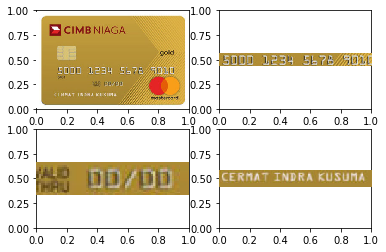

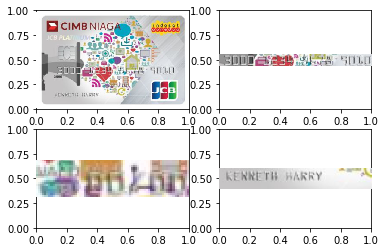

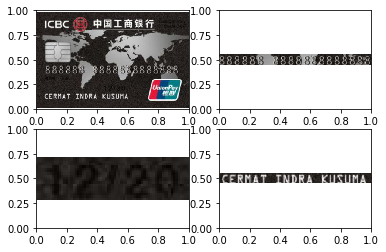

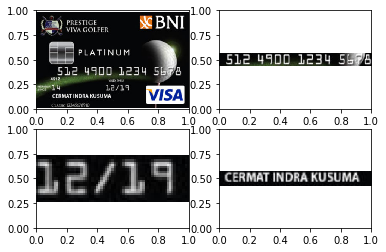

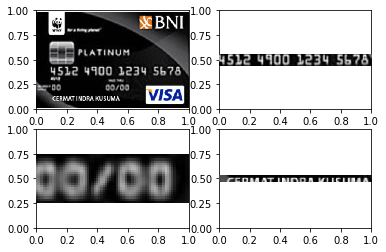

In [74]:
from tensorflow.keras.models import load_model

model = load_model(
        '/tf/ocr_credit_card/artifact/ocr_credit_card_20200206.h5',
        custom_objects={'cumulative_loss': cumulative_loss, 'iou_metric': iou_metric},
        compile=False)

result = model.predict(x_test)
pred = pd.DataFrame(result, columns=final_data.columns[:12])

pred = transform_numerical(
    pred, excludes=[], 
    min_y=0.0, max_y=410.0, 
    min_x=0.0, max_x=260.0,
    calc=inverse_normalizer)

for i in range(pred.shape[1]):
    
    if i == 5:
        break

    im = x_test[i]

    fig, ax = plt.subplots(nrows=2, ncols=2)
    ax = fig.add_subplot(221)
    ax.axis('off')
    plt.imshow(im)

    ax = fig.add_subplot(222)
    ax.axis('off')
    imc_1 = im[
        int(pred['numY1'][i]):int(pred['numY2'][i]), 
        int(pred['numX1'][i]):int(pred['numX2'][i])]
    plt.imshow(imc_1)

    ax = fig.add_subplot(223)
    ax.axis('off')
    imc_2 = im[
        int(pred['dateY1'][i]):int(pred['dateY2'][i]), 
        int(pred['dateX1'][i]):int(pred['dateX2'][i])]
    plt.imshow(imc_2)

    ax = fig.add_subplot(224)
    ax.axis('off')
    imc_3 = im[
        int(pred['nameY1'][i]):int(data['nameY2'][i]), 
        int(pred['nameX1'][i]):int(pred['nameX2'][i])]
    plt.imshow(imc_3)
    plt.show()
    


## K-Fold Validation

In [14]:
import datetime
from numpy import savetxt
from sklearn.model_selection import KFold

EXPERIMENT = 2


def load_data_kfold(k, dataset):
    X = load_images(IMAGE_DIR, final_data, IMAGE_SIZE)
    Y = dataset.iloc[:, :-10].values
    folds = list(KFold(n_splits=k, shuffle=True, random_state=1).split(X, Y))
    return folds, X, Y


def l2_loss(target_box, pred_box):
    xA, yA = target_box[0], target_box[1]
    xB, yB = pred_box[0], pred_box[1]
    loss = (((xB - xA)**2) + ((yB-yA)**2))**(1/2)
    return loss


def run_kfold(experiment_id, dataset):
    result = []
    t = str(datetime.date.today()).replace('-', '')
    folds, X, Y = load_data_kfold(10, dataset)
    
    counter = 0 
    
    for train_i, test_i in folds:
        print('Begining model training on fold {0}'.format(counter+1))
        model = create_model()
        x_train, y_train = X[train_i], Y[train_i]
        x_test, y_test = X[test_i], Y[test_i]
        model.fit( 
            x_train,
            y_train, 
            validation_data=(x_test, y_test),
            epochs=100,
            verbose=0,
            batch_size=1
        )
        pred = model.predict(x_test)
        result.append(pred)
        
        artifact_name = 'model_experiment_{0}_fold_{1}_{2}.h5'.format(experiment_id, counter + 1, t)
        model.save(ARTIFACT_PATH + artifact_name)
        counter += 1
        print('Finish model training on fold {0}'.format(counter+1))
    
    return result


# val_result = run_kfold(EXPERIMENT, final_data)
# val_result = np.array(val_result)

# np.save(ARTIFACT_PATH + 'kfold_experiment_{0}.npy'.format(EXPERIMENT), val_result)

## Load K-fold Validation Result

Average error based on euclidean distance for each coordinates: [ 7.5391362  10.30523922 10.18278949  8.91497239  7.15127604 18.82325121]
Overall average error based on eucliden distance of coordinates: 10.486110760027486


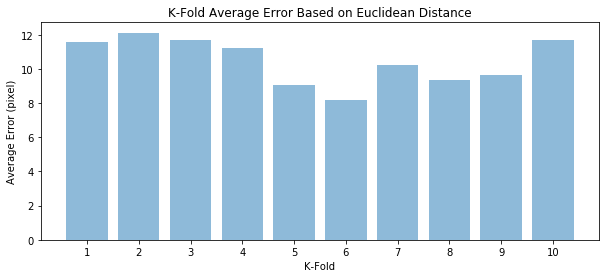

In [70]:
folds, X, Y = load_data_kfold(10, final_data)
summary = np.load(ARTIFACT_PATH + 'experiment_2/' +'kfold_experiment_2.npy', allow_pickle=True)
# summary = pd.DataFrame(summary[0], columns=final_data.columns[:12])


losses = []
for i in range(len(folds)):
    test_i = folds[i][1]
    eval_data = data.drop(['file'], axis=1)
    eval_data = eval_data.iloc[test_i]
    k_summary = pd.DataFrame(summary[i], columns=final_data.columns[:12])
    
    k_summary = transform_numerical(
        k_summary, excludes=[], 
        min_y=0.0, max_y=410.0, 
        min_x=0.0, max_x=260.0,
        calc=inverse_normalizer)
    
    l2_loss = (eval_data.values - k_summary.values)**2
    losses.append(l2_loss)
    

errors = []
for loss in losses:
    distances = []
    for i in range(loss.shape[1]):
        if loss.shape[1] - i < 2:
            break
        if i % 2 != 0:
            continue    
        x_coords, y_coords = loss[:, i], loss[:, i+1]
        dist = (x_coords + y_coords)**(1/2)
        dist_avg = np.average(dist) # Calculate the average distance
        distances.append(dist_avg)
    errors.append(distances)
errors = np.array(errors)


avg_error = np.average(errors, axis=0)
print('Average error based on euclidean distance for each coordinates: {0}'.format(avg_error))

avg_error_overall = np.average(avg_error)
print('Overall average error based on eucliden distance of coordinates: {0}'.format(avg_error_overall))


# Plot average error for each fold
folds = np.arange(1, 11, 1).tolist()
k_fold_avg_err = np.average(errors, axis=1).tolist()

err_min_idx = np.argmin(k_fold_avg_err)
err_max_idx = np.argmax(k_fold_avg_err)

plt.figure(figsize=(10, 4))
plt.bar(folds, k_fold_avg_err, align='center', alpha=0.5)
plt.xticks(folds, folds)
plt.ylabel('Average Error (pixel)')
plt.xlabel('K-Fold')
plt.title('K-Fold Average Error Based on Euclidean Distance')
plt.show()


## Load K-Fold Validation Model

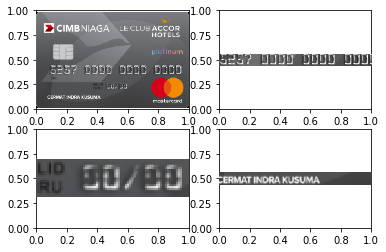

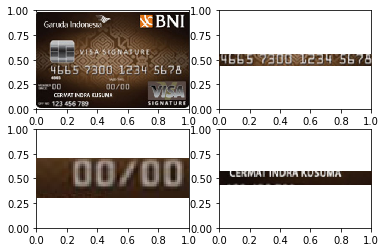

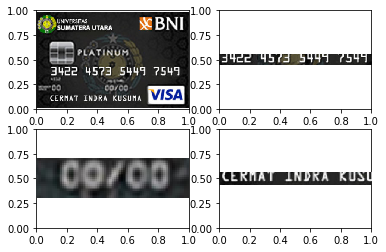

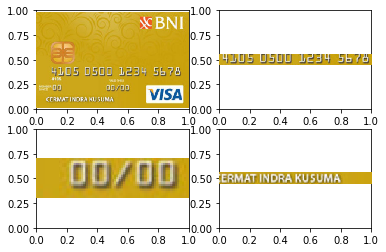

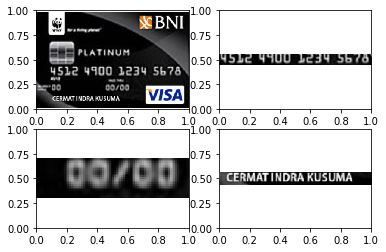

In [89]:
import glob
import tensorflow as tf
from tensorflow.keras.models import load_model


EXPERIMENT_PATH = ARTIFACT_PATH + 'experiment_1/'

listing = glob.glob(EXPERIMENT_PATH + '*.h5')
folds, X, Y = load_data_kfold(10, final_data)



for i in range(err_min_idx, len(listing)):
#     with tf.device('/cpu:0'):
    model = load_model(
        listing[i],
        custom_objects={'cumulative_loss': cumulative_loss, 'iou_metric': iou_metric},
        compile=False)
        
    _, test_i = folds[i]
    x_test = X[test_i]

    result = model.predict(x_test)
    pred = pd.DataFrame(result, columns=final_data.columns[:12])
    
    pred = transform_numerical(
        pred, excludes=[], 
        min_y=0.0, max_y=410.0, 
        min_x=0.0, max_x=260.0,
        calc=inverse_normalizer)
    
    for j in range(pred.shape[0]):
        
        if j == 5:
            break
        
        im = x_test[j]
        
        fig, ax = plt.subplots(nrows=2, ncols=2)
        ax = fig.add_subplot(221)
        ax.axis('off')
        plt.imshow(im)
        
        ax = fig.add_subplot(222)
        ax.axis('off')
        imc_1 = im[
            int(pred['numY1'][j]):int(pred['numY2'][j]), 
            int(pred['numX1'][j]):int(pred['numX2'][j])]
        plt.imshow(imc_1)
        
        ax = fig.add_subplot(223)
        ax.axis('off')
        imc_2 = im[
            int(pred['dateY1'][j]):int(pred['dateY2'][j]), 
            int(pred['dateX1'][j]):int(pred['dateX2'][j])]
        plt.imshow(imc_2)
        
        ax = fig.add_subplot(224)
        ax.axis('off')
        imc_3 = im[
            int(pred['nameY1'][j]):int(pred['nameY2'][j]), 
            int(pred['nameX1'][j]):int(pred['nameX2'][j])]
        plt.imshow(imc_3)
        plt.show()
        
    break
    
    
# X = load_images(IMAGE_DIR, final_data, IMAGE_SIZE)
# model.predict()


## Find IOU Threshold

In [59]:
import glob
import tensorflow as tf
from tensorflow.keras.models import load_model


EXPERIMENT_PATH = ARTIFACT_PATH + 'experiment_2/'

listing = glob.glob(EXPERIMENT_PATH + '*.h5')
folds, X, Y = load_data_kfold(10, final_data)


def exec_validation_on(saved_model, x_val, lbl_col):
    model = load_model(
        saved_model,
        custom_objects={'cumulative_loss': cumulative_loss, 'iou_metric': iou_metric},
        compile=False)
    result = model.predict(x_val)
    pred = pd.DataFrame(result, columns=lbl_col)
    pred = transform_numerical(
        pred, excludes=[], 
        min_y=0.0, max_y=410.0, 
        min_x=0.0, max_x=260.0,
        calc=inverse_normalizer)
    return pred


def iou_eval(target_boxes, pred_boxes):
    iou = []
    counter = 0
    
    for i in range(NUM_OBJECTS):
        
        xA = tf.maximum(target_boxes[:, counter], pred_boxes[:, counter])
        yA = tf.maximum(target_boxes[:, counter+1], pred_boxes[:, counter+1])
        xB = tf.minimum(target_boxes[:, counter+2], pred_boxes[:, counter+2])
        yB = tf.minimum(target_boxes[:, counter+3], pred_boxes[:, counter+3])

        inter_area = tf.maximum(0.0, xB - xA) *  tf.maximum(0.0, yB - yA)

        boxA_area = (target_boxes[:, counter+2] - target_boxes[:, counter]) * (target_boxes[:, counter+3] - target_boxes[:, counter+1])
        boxB_area = (pred_boxes[:, counter+2] - pred_boxes[:, counter]) * (pred_boxes[:,counter+ 3] - pred_boxes[:, counter+1])

        iou_val = inter_area / (boxA_area + boxB_area - inter_area)
        
        iou.append(iou_val.numpy()[0])
        counter += NUM_OBJECTS + 1
    
    return iou


def calculate_iou(listing, X):
    iou_set = []
    gt_idx = []
    
    for i in range(len(listing)):
        ious = []
        _, test_i = folds[i]
        x_test = X[test_i]
        lbl_col = final_data.columns[:12]
        
        pred = exec_validation_on(listing[i], x_test, lbl_col)
        target = pre_data.iloc[test_i, :12]

        for j in range(target.shape[0]):
            pred_box = np.expand_dims(pred.iloc[j].values, axis=0)
            target_box = np.expand_dims(target.iloc[j].values, axis=0)
            iou = iou_eval(target_box, pred_box)
            ious.append(iou)
            
        iou_set.append(ious)
        gt_idx.append(x_test.shape[0])
        
    return iou_set, gt_idx


In [74]:
from sklearn.metrics import confusion_matrix


iou_thres = 0.5


def get_single_object_results(ious, iou_thres):
    true_positive = []
    false_positive = []
    false_negative = []
    ious_indicies = range(len(ious))
    
    if len(ious_indicies) == 0:
        return {'true_positive':0, 'false_positive':0, 'false_negative':0}
    
    for idx, iou in enumerate(ious):
        if iou > iou_thres:
            true_positive.append(idx)
        else:
            false_positive.append(idx)
    
    return {'true_positive': len(true_positive), 'false_positive': len(false_positive), 'false_negative': len(false_negative)}


def get_multiple_object_result(iou_set, iou_thres):
    k_scores = []
    for ious in iou_set:
        summaries = []
        k_ious = np.array(ious)
        for idx in range(k_ious.shape[1]):
            scores = get_single_object_results(k_ious[:, idx], iou_thres)
            summaries.append(scores)
        result = {'number': summaries[0], 'date': summaries[1], 'name': summaries[2]}
        k_scores.append(result)
    return k_scores

 
def compute_precision(iou_set, gt_idx, iou_thres):
    precisions = []
    recalls = []
    k_scores = get_multiple_object_result(iou_set, iou_thres)
    for idx, scores in enumerate(k_scores):
        precision_summary = []
        recall_summary = []
        for key in scores:
            tp = scores[key]['true_positive']
            fp = scores[key]['false_positive']
            precision =  tp/(tp+fp)
            recall = tp/gt_idx[idx]
            precision_summary.append(precision)
            recall_summary.append(recall)
        result_precision = {'number': precision_summary[0], 'date': precision_summary[1], 'name': precision_summary[2]}
        result_recall = {'number': recall_summary[0], 'date': recall_summary[1], 'name': recall_summary[2]}
        precisions.append(result_precision)
        recalls.append(result_recall)
    return precisions, recalls, k_scores


def get_avg_precision_at_iou(gt_boxes, pred_bb, iou_thres=0.5):
    return


def compute_accuracy():
    # compute accuracy by turn it into binary by using threshold over IoU
    return


# iou_set, gt_idx = calculate_iou(listing, X)
precisions, recalls, k_scores = compute_precision(iou_set, gt_idx, iou_thres)
print('Precision on each object fold {0}: {1}'.format(err_min_idx, precisions[err_min_idx]))
print('Recall on each object fold {0}: {1}'.format(err_min_idx, recalls[err_min_idx]))
print('\n')
print('Precision on each object fold {0}: {1}'.format(err_max_idx, precisions[err_max_idx]))
print('Recall on each object fold {0}: {1}'.format(err_max_idx, recalls[err_max_idx]))


Precision on each object fold 5: {'number': 1.0, 'date': 0.971830985915493, 'name': 1.0}
Recall on each object fold 5: {'number': 1.0, 'date': 0.971830985915493, 'name': 1.0}


Precision on each object fold 1: {'number': 0.9722222222222222, 'date': 0.9583333333333334, 'name': 0.9583333333333334}
Recall on each object fold 1: {'number': 0.9722222222222222, 'date': 0.9583333333333334, 'name': 0.9583333333333334}


## Plot Prediction Result

In [ ]:
def plot_prediction_res(model, data, label_columns):
    pred = model.predict(data)
    pred_df = pd.DataFrame(pred, columns=label_columns)
    
    pred_data = transform_numerical(
        pred_df, excludes=[], 
        min_y=0.0, max_y=410.0, 
        min_x=0.0, max_x=260.0,
        calc=inverse_normalizer)
    
    for i in range(data.shape[0]):
        im = data[i]
        coords = pred_data.loc[i]

        cv2.rectangle(im, 
                      (int(coords['numX2']), int(coords['numY2'])), 
                      (int(coords['numX1']), int(coords['numY1'])), 
                      (255,0,0))
        cv2.rectangle(im, 
                      (int(coords['dateX2']), int(coords['dateY2'])), 
                      (int(coords['dateX1']), int(coords['dateY1'])), 
                      (255,0,0))
        cv2.rectangle(im, 
                      (int(coords['nameX2']), int(coords['nameY2'])), 
                      (int(coords['nameX1']), int(coords['nameY1'])), 
                      (255,0,0))

        
        plt.figure()
        plt.axis('off')
        plt.imshow(im)
        plt.show()


In [ ]:
plot_prediction_res(model, x_test, label_columns=final_data.columns[:12])